In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
ratings = pd.read_csv('/content/sample_data/ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

In [ ]:
ratings

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
...,...,...,...,...,...
1000204,6040,1091,1,6039,1090
1000205,6040,1094,5,6039,1093
1000206,6040,562,5,6039,561
1000207,6040,1096,4,6039,1095


In [ ]:
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()
print(max_userid)
print(max_movieid)

6040
3952


In [ ]:
users = pd.read_csv('/content/sample_data/users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

In [ ]:
users

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer
...,...,...,...,...,...
6035,6036,F,32603,25-34,scientist
6036,6037,F,76006,45-49,academic/educator
6037,6038,F,14706,56+,academic/educator
6038,6039,F,01060,45-49,other or not specified


In [ ]:
movies = pd.read_csv('/content/sample_data/movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [ ]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:

# Create training set
RNG_SEED = 32
shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [3620 2624 1259 ... 3945 2164   80] , shape = (1000209,)
Movies: [3571 1993 3504 ... 2139 3267  110] , shape = (1000209,)
Ratings: [1 3 4 ... 4 3 5] , shape = (1000209,)


In [ ]:
# import numpy as np
# import tensorflow as tf

# from keras.layers import Embedding, Reshape, dot
# from keras.models import Sequential

# class CFModel(Sequential):

#     # The constructor for the class
#     def __init__(self, n_users, m_items, k_factors, **kwargs):
#         # P is the embedding layer that creates an User by latent factors matrix.
#         # If the intput is a user_id, P returns the latent factor vector for that user.
#         P = Sequential()
#         P.add(Embedding(n_users, k_factors, input_length=1))
#         P.add(Reshape((k_factors,)))

#         # Q is the embedding layer that creates a Movie by latent factors matrix.
#         # If the input is a movie_id, Q returns the latent factor vector for that movie.
#         Q = Sequential()
#         Q.add(Embedding(m_items, k_factors, input_length=1))
#         Q.add(Reshape((k_factors,)))

#         super(CFModel, self).__init__(**kwargs)
        
#         # The Merge layer takes the dot product of user and movie latent factor vectors to return the corresponding rating.
#         keras.layers.dot([P, Q], axes=1)
        
#     # The rate function to predict user's rating of unrated items
#     def rate(self, user_id, item_id):
#         return self.predict([np.array([user_id]), np.array([item_id])])[0][0]


In [ ]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Concatenate, dot
from keras import Input
from keras.optimizers import Adagrad

k_factors = 100
input_1 = Input(shape=(1,))
input_2 = Input(shape=(1,))
P = Reshape((k_factors,))(Embedding(max_userid, k_factors, input_length=1)(input_1))
Q = Reshape((k_factors,))(Embedding(max_movieid, k_factors, input_length=1)(input_2))
P_dot_Q = dot([P, Q], axes=1, normalize=True)
model = Model(inputs=[input_1, input_2], outputs=P_dot_Q)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_76 (Embedding)        (None, 1, 100)       604000      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_77 (Embedding)        (None, 1, 100)       395200      input_5[0][0]                    
____________________________________________________________________________________________

In [ ]:
import tensorflow as tf

def plot_model(model):
  return tf.keras.utils.plot_model(
            model, show_shapes=True, expand_nested=True)

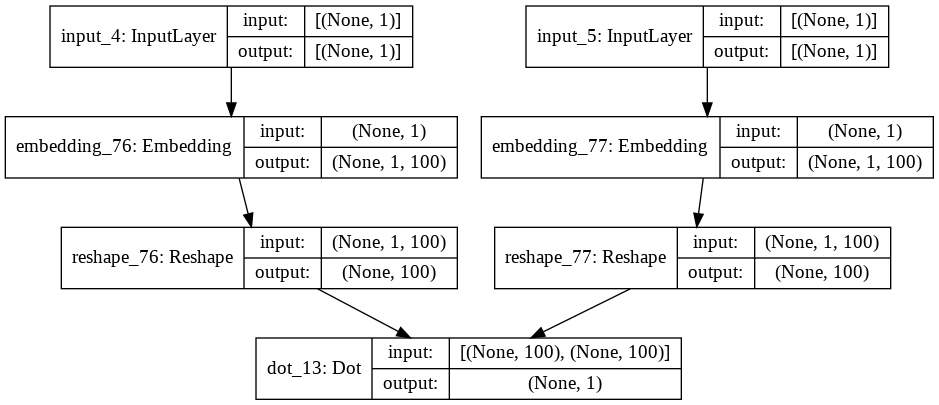

In [ ]:
plot_model(model)

In [ ]:
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

In [ ]:
save_model(model, 'weights') #save baseline CNN model

Saved trained model at /content/saved_models/weights.h5 


In [ ]:
model.compile(loss='mse', optimizer='adamax')
callbacks = [EarlyStopping('val_loss', patience=2), ModelCheckpoint('weights.h5', save_best_only=True)]

In [ ]:
history = model.fit([Users, Movies], Ratings, epochs=30, validation_split=.1, verbose=2, callbacks=callbacks)

Epoch 1/30
28131/28131 - 67s - loss: 7.9145 - val_loss: 7.9044
Epoch 2/30
28131/28131 - 67s - loss: 7.9145 - val_loss: 7.9044
Epoch 3/30
28131/28131 - 66s - loss: 7.9144 - val_loss: 7.9043
Epoch 4/30


KeyboardInterrupt: ignored